# Diffusion Model Acceleration Techniques

## Abstract

Diffusion models have emerged as one of the most powerful generative modeling approaches, achieving state-of-the-art results in image synthesis, text-to-image generation, and various other domains. However, their iterative denoising process requires multiple forward passes, making inference computationally expensive. This notebook demonstrates the use of pretrained diffusion models and explores the foundation for various acceleration techniques.

## Introduction

Diffusion models work by gradually adding noise to data during training and learning to reverse this process during inference. The inference process typically requires 50-1000 denoising steps, which can be time-consuming for practical applications. In this workshop, we will:

1. **Load and use a pretrained diffusion model** for image generation
2. **Understand the denoising process** and computational bottlenecks
3. **Analyze inference time and quality trade-offs**
4. **Establish baseline performance** for future optimization techniques

### Key Concepts:
- **Forward Process**: Gradually adding Gaussian noise to destroy data structure
- **Reverse Process**: Learning to denoise and generate new samples
- **Sampling Steps**: Number of denoising iterations required for generation
- **Computational Cost**: Memory and time requirements for inference

## 1. Environment Setup and Dependencies

First, we install and import the necessary libraries for our diffusion model implementation.

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import time
from PIL import Image
from diffusers import StableDiffusionPipeline, DDIMScheduler, DDPMScheduler
import warnings
warnings.filterwarnings('ignore')

# Set device and memory optimization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name()}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Configure plotting
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)

Using device: cuda
CUDA available: True
GPU: GRID A100X-10C
GPU Memory: 10.0 GB


## 2. Theoretical Background

### Diffusion Model Overview

Diffusion models are generative models that learn to reverse a gradual noise addition process. The training consists of two processes:

**Forward Process (Noise Addition):**
- Start with real data x₀
- Gradually add Gaussian noise over T timesteps
- Each step: q(xₜ|xₜ₋₁) = N(xₜ; √(1-βₜ)xₜ₋₁, βₜI)
- Final result: xₜ ≈ N(0,I) (pure noise)

**Reverse Process (Denoising):**
- Learn to predict the noise added at each step
- Start from pure noise xₜ ~ N(0,I)
- Iteratively denoise: p(xₜ₋₁|xₜ) = N(xₜ₋₁; μθ(xₜ,t), Σθ(xₜ,t))
- Final result: x₀ (generated sample)

### Computational Challenges

1. **Multiple Forward Passes**: Requires 50-1000 denoising steps
2. **Large Model Size**: UNet architectures with millions of parameters
3. **High Memory Usage**: Intermediate activations for each timestep
4. **Sequential Nature**: Steps must be computed sequentially

## 3. Loading Pretrained Diffusion Model

We'll use Stable Diffusion, a popular text-to-image diffusion model. The model consists of several components:
- **Text Encoder**: Converts text prompts to embeddings
- **UNet**: The core denoising network
- **VAE Decoder**: Converts latent representations to images
- **Scheduler**: Controls the denoising process

In [2]:
# Load Stable Diffusion model
model_id = "runwayml/stable-diffusion-v1-5"

try:
    # Load the pipeline with memory optimization
    pipe = StableDiffusionPipeline.from_pretrained(
        model_id,
        torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
        safety_checker=None,
        requires_safety_checker=False
    )
    
    # Move to device and optimize memory
    pipe = pipe.to(device)
    
    # Apply memory optimization techniques (updated for newer diffusers versions)
    if device.type == "cuda":
        # Enable memory efficient attention and slicing
        pipe.enable_attention_slicing()
        # Enable CPU offloading if needed to save GPU memory
        # pipe.enable_sequential_cpu_offload()  # Uncomment if you have memory issues
        
        # Enable xformers for better memory efficiency (if available)
        try:
            pipe.enable_xformers_memory_efficient_attention()
            print("✅ XFormers memory efficient attention enabled")
        except Exception:
            print("ℹ️  XFormers not available, using default attention")
    
    print("✅ Stable Diffusion model loaded successfully!")
    print(f"Model components:")
    print(f"  - Text Encoder: {type(pipe.text_encoder).__name__}")
    print(f"  - UNet: {type(pipe.unet).__name__}")
    print(f"  - VAE: {type(pipe.vae).__name__}")
    print(f"  - Scheduler: {type(pipe.scheduler).__name__}")
    
except Exception as e:
    print(f"❌ Error loading model: {e}")
    print("This might be due to memory constraints or missing dependencies.")
    print("💡 Try installing xformers for better memory efficiency: pip install xformers")

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

✅ XFormers memory efficient attention enabled
✅ Stable Diffusion model loaded successfully!
Model components:
  - Text Encoder: CLIPTextModel
  - UNet: UNet2DConditionModel
  - VAE: AutoencoderKL
  - Scheduler: PNDMScheduler


## 4. Model Architecture Analysis

Let's examine the model architecture to understand the computational requirements and identify potential optimization targets.

In [3]:
# Analyze model architecture and parameters
def count_parameters(model):
    """Count the total number of parameters in a model"""
    return sum(p.numel() for p in model.parameters())

def analyze_model_components():
    """Analyze each component of the diffusion model"""
    if 'pipe' not in globals():
        print("❌ Model not loaded. Please run the previous cell first.")
        return
    
    components = {
        'Text Encoder': pipe.text_encoder,
        'UNet': pipe.unet,
        'VAE Encoder': pipe.vae.encoder,
        'VAE Decoder': pipe.vae.decoder
    }
    
    print("🔍 Model Architecture Analysis:")
    print("=" * 50)
    
    total_params = 0
    for name, component in components.items():
        params = count_parameters(component)
        total_params += params
        print(f"{name:15}: {params:,} parameters ({params/1e6:.1f}M)")
    
    print("-" * 50)
    print(f"{'Total':15}: {total_params:,} parameters ({total_params/1e6:.1f}M)")
    
    # Memory usage estimation
    if torch.cuda.is_available():
        print(f"\n📊 Memory Usage:")
        print(f"Current GPU memory: {torch.cuda.memory_allocated()/1024**3:.2f} GB")
        print(f"Peak GPU memory: {torch.cuda.max_memory_allocated()/1024**3:.2f} GB")

analyze_model_components()

🔍 Model Architecture Analysis:
Text Encoder   : 123,060,480 parameters (123.1M)
UNet           : 859,520,964 parameters (859.5M)
VAE Encoder    : 34,163,592 parameters (34.2M)
VAE Decoder    : 49,490,179 parameters (49.5M)
--------------------------------------------------
Total          : 1,066,235,215 parameters (1066.2M)

📊 Memory Usage:
Current GPU memory: 2.01 GB
Peak GPU memory: 2.01 GB


## 5. Baseline Image Generation

Let's generate some images using the pretrained model to establish baseline performance metrics.

In [4]:
def generate_image_with_timing(prompt, num_inference_steps=50, guidance_scale=7.5, seed=42):
    """Generate an image and measure the inference time"""
    if 'pipe' not in globals():
        print("❌ Model not loaded. Please run the model loading cell first.")
        return None, 0
    
    # Set seed for reproducibility
    generator = torch.Generator(device=device).manual_seed(seed)
    
    # Measure inference time
    start_time = time.time()
    
    with torch.no_grad():
        image = pipe(
            prompt,
            num_inference_steps=num_inference_steps,
            guidance_scale=guidance_scale,
            generator=generator,
            height=512,
            width=512
        ).images[0]
    
    end_time = time.time()
    inference_time = end_time - start_time
    
    return image, inference_time

# Test prompts for demonstration
test_prompts = [
    "A serene landscape with mountains and a lake at sunset",
    "A cute robot playing with a cat in a garden",
    "An abstract painting with vibrant colors and geometric shapes"
]

print("🎨 Ready to generate images!")
print("Test prompts available:")
for i, prompt in enumerate(test_prompts, 1):
    print(f"{i}. {prompt}")

🎨 Ready to generate images!
Test prompts available:
1. A serene landscape with mountains and a lake at sunset
2. A cute robot playing with a cat in a garden
3. An abstract painting with vibrant colors and geometric shapes


🚀 Running baseline experiments...

📝 Prompt 1: A serene landscape with mountains and a lake at sunset
----------------------------------------


  0%|          | 0/50 [00:00<?, ?it/s]

⏱️  Generation time: 3.15 seconds
🧠 Peak GPU memory: 2.61 GB


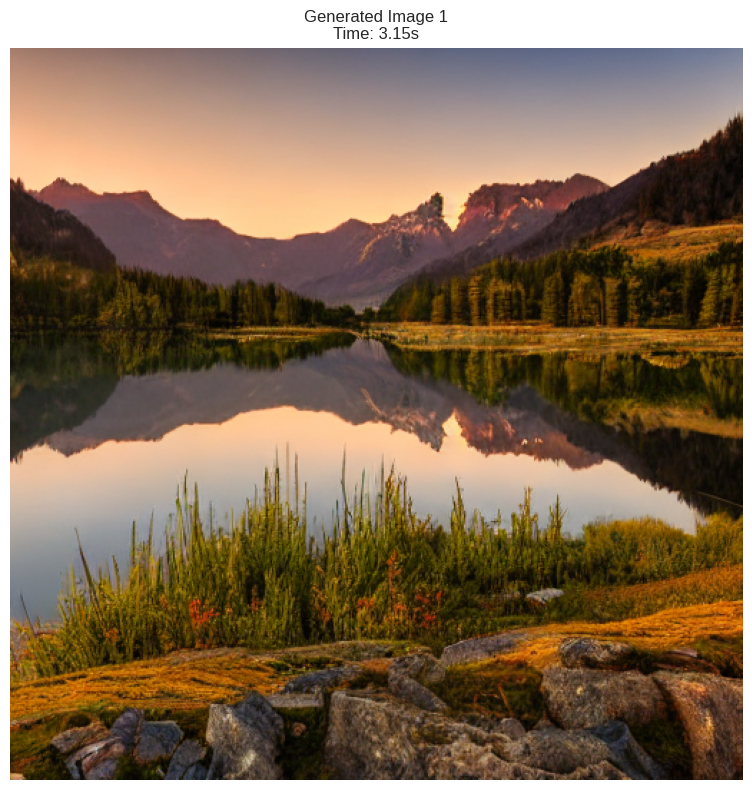


📝 Prompt 2: A cute robot playing with a cat in a garden
----------------------------------------


  0%|          | 0/50 [00:00<?, ?it/s]

⏱️  Generation time: 2.40 seconds
🧠 Peak GPU memory: 2.61 GB


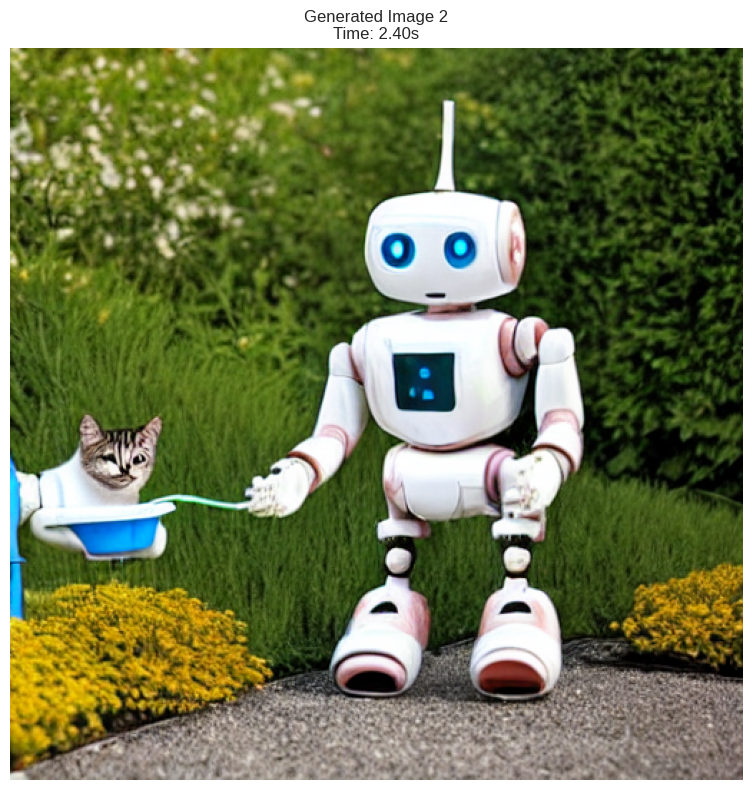


📝 Prompt 3: An abstract painting with vibrant colors and geometric shapes
----------------------------------------


  0%|          | 0/50 [00:00<?, ?it/s]

⏱️  Generation time: 2.40 seconds
🧠 Peak GPU memory: 2.61 GB


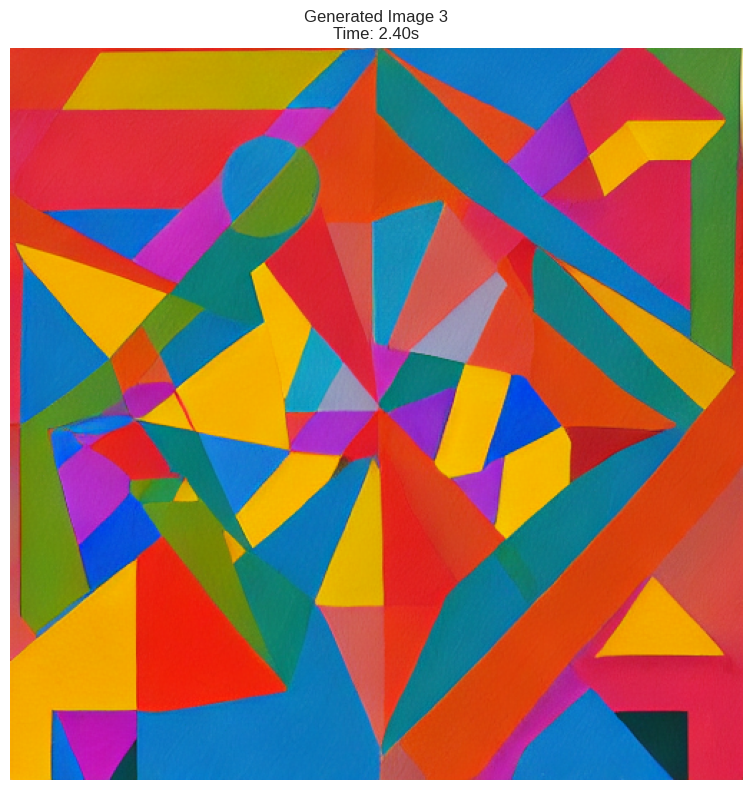

In [5]:
# Generate images with different prompts and analyze performance
def run_baseline_experiments():
    """Run baseline experiments with different prompts and settings"""
    if 'pipe' not in globals():
        print("❌ Model not loaded. Please run the model loading cell first.")
        return
    
    results = []
    
    print("🚀 Running baseline experiments...")
    print("=" * 60)
    
    for i, prompt in enumerate(test_prompts):
        print(f"\n📝 Prompt {i+1}: {prompt}")
        print("-" * 40)
        
        # Generate image with timing
        image, inference_time = generate_image_with_timing(prompt, num_inference_steps=50)
        
        if image is not None:
            print(f"⏱️  Generation time: {inference_time:.2f} seconds")
            
            # Memory usage if on GPU
            if torch.cuda.is_available():
                memory_used = torch.cuda.max_memory_allocated() / 1024**3
                print(f"🧠 Peak GPU memory: {memory_used:.2f} GB")
                torch.cuda.reset_peak_memory_stats()
            
            results.append({
                'prompt': prompt,
                'inference_time': inference_time,
                'image': image
            })
            
            # Display the generated image
            plt.figure(figsize=(8, 8))
            plt.imshow(image)
            plt.axis('off')
            plt.title(f"Generated Image {i+1}\nTime: {inference_time:.2f}s")
            plt.tight_layout()
            plt.show()
        else:
            print("❌ Failed to generate image")
    
    return results

# Run the baseline experiments
baseline_results = run_baseline_experiments()

## 6. Analyzing the Impact of Inference Steps

One of the key factors affecting both quality and speed is the number of denoising steps. Let's analyze this trade-off.

🔬 Analyzing inference step trade-offs...

🔄 Testing with 10 inference steps...


  0%|          | 0/10 [00:00<?, ?it/s]

   ⏱️  Time: 0.58s

🔄 Testing with 20 inference steps...


  0%|          | 0/20 [00:00<?, ?it/s]

   ⏱️  Time: 1.02s

🔄 Testing with 30 inference steps...


  0%|          | 0/30 [00:00<?, ?it/s]

   ⏱️  Time: 1.48s

🔄 Testing with 50 inference steps...


  0%|          | 0/50 [00:00<?, ?it/s]

   ⏱️  Time: 2.39s

🔄 Testing with 100 inference steps...


  0%|          | 0/100 [00:00<?, ?it/s]

   ⏱️  Time: 4.68s


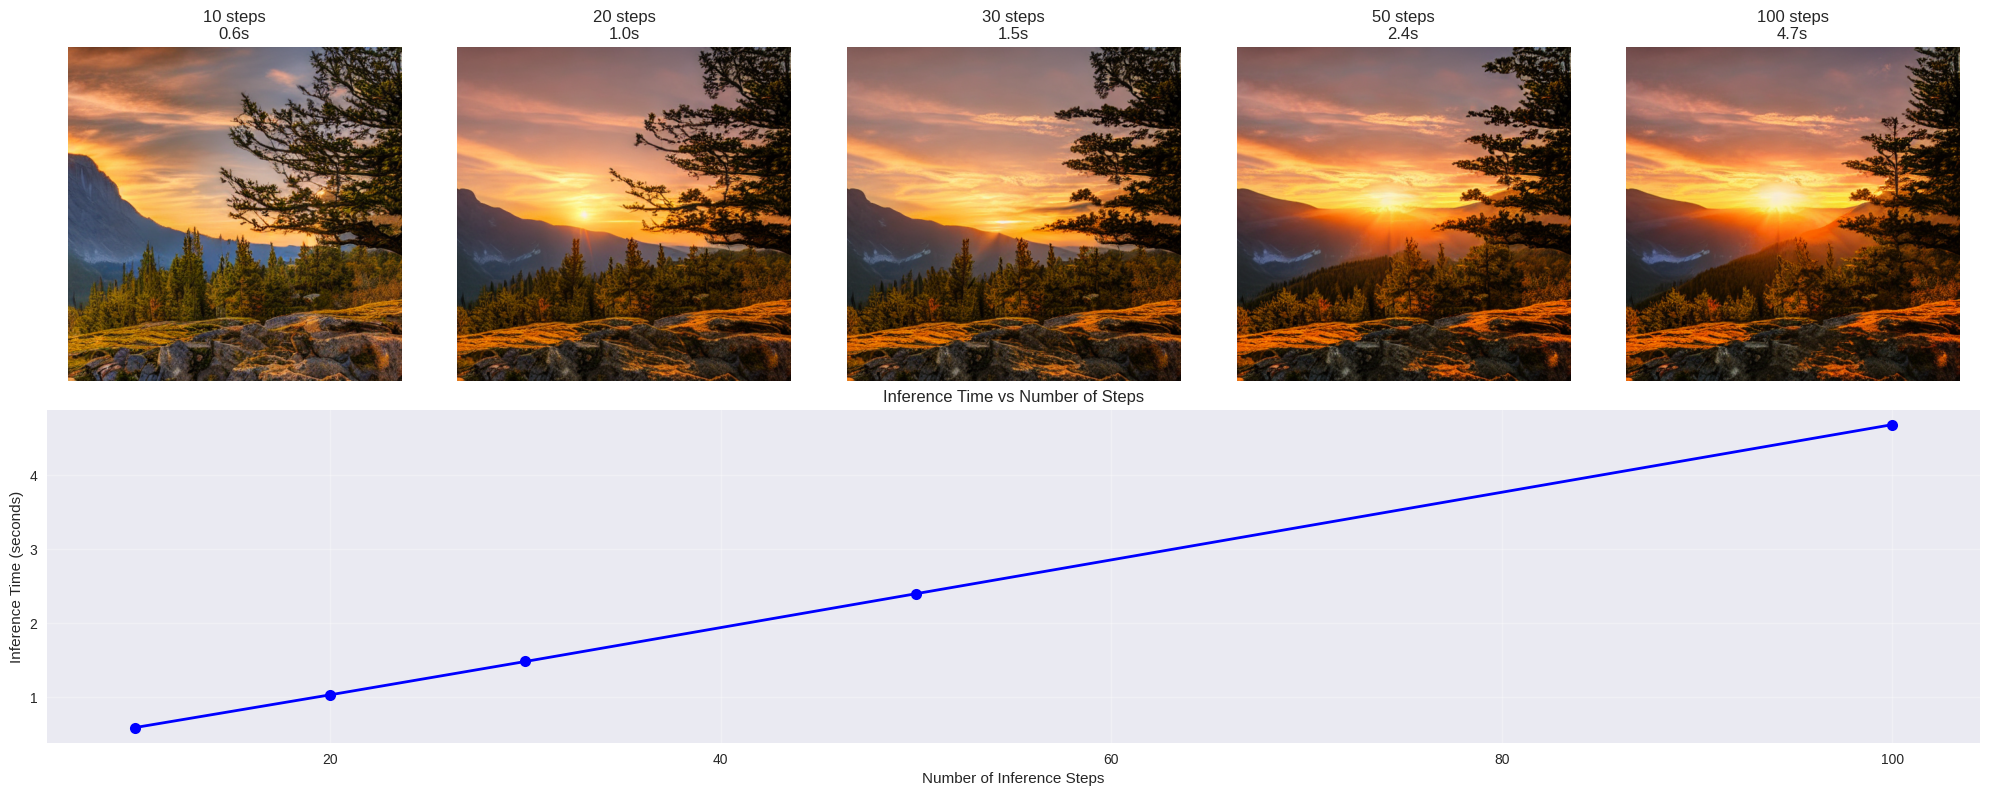

In [6]:
def analyze_step_count_tradeoff():
    """Analyze the trade-off between inference steps and generation time/quality"""
    if 'pipe' not in globals():
        print("❌ Model not loaded. Please run the model loading cell first.")
        return
    
    step_counts = [10, 20, 30, 50, 100]
    test_prompt = "A beautiful sunset over a mountain landscape"
    
    results = {}
    images = {}
    
    print("🔬 Analyzing inference step trade-offs...")
    print("=" * 50)
    
    for steps in step_counts:
        print(f"\n🔄 Testing with {steps} inference steps...")
        
        # Generate image with different step counts
        image, inference_time = generate_image_with_timing(
            test_prompt, 
            num_inference_steps=steps,
            seed=42
        )
        
        if image is not None:
            results[steps] = inference_time
            images[steps] = image
            print(f"   ⏱️  Time: {inference_time:.2f}s")
        else:
            print(f"   ❌ Failed to generate image with {steps} steps")
    
    # Create visualization
    if results:
        fig, axes = plt.subplots(2, len(step_counts), figsize=(20, 8))
        
        # Plot images in first row
        for i, steps in enumerate(step_counts):
            if steps in images:
                axes[0, i].imshow(images[steps])
                axes[0, i].set_title(f"{steps} steps\n{results[steps]:.1f}s")
                axes[0, i].axis('off')
        
        # Plot timing analysis in second row
        steps_list = list(results.keys())
        times_list = list(results.values())
        
        # Merge the subplot for timing graph
        for i in range(len(step_counts)):
            axes[1, i].remove()
        
        ax_timing = fig.add_subplot(2, 1, 2)
        ax_timing.plot(steps_list, times_list, 'bo-', linewidth=2, markersize=8)
        ax_timing.set_xlabel('Number of Inference Steps')
        ax_timing.set_ylabel('Inference Time (seconds)')
        ax_timing.set_title('Inference Time vs Number of Steps')
        ax_timing.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        return results, images
    
    return None, None

# Run the step count analysis
step_results, step_images = analyze_step_count_tradeoff()

## 7. Scheduler Comparison

Different schedulers can significantly impact both generation quality and speed. Let's compare different sampling schedulers.

🔄 Comparing different schedulers...

🧪 Testing DDIM scheduler...


  0%|          | 0/25 [00:00<?, ?it/s]

   ⏱️  Time: 1.23s

🧪 Testing DDPM scheduler...


  0%|          | 0/25 [00:00<?, ?it/s]

   ⏱️  Time: 1.25s

🧪 Testing LMS scheduler...


  0%|          | 0/25 [00:00<?, ?it/s]

   ⏱️  Time: 1.31s

🧪 Testing PNDM scheduler...


  0%|          | 0/25 [00:00<?, ?it/s]

   ⏱️  Time: 1.26s

🧪 Testing Euler scheduler...


  0%|          | 0/25 [00:00<?, ?it/s]

   ⏱️  Time: 1.21s


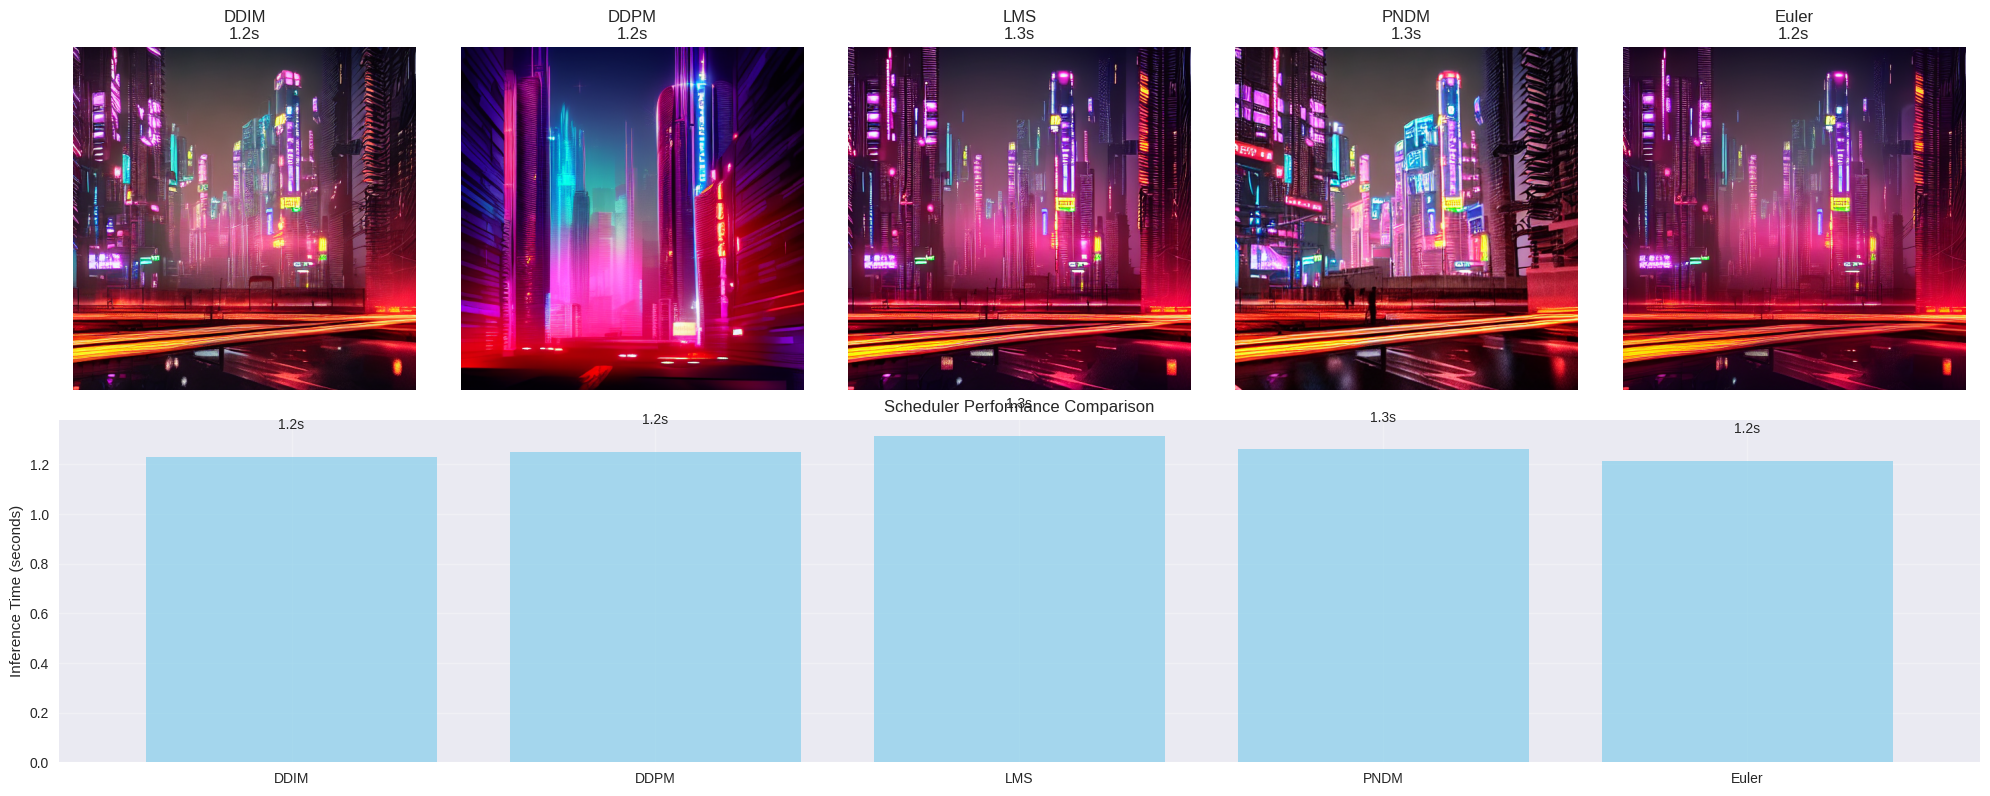

In [7]:
def compare_schedulers():
    """Compare different schedulers for diffusion model inference"""
    if 'pipe' not in globals():
        print("❌ Model not loaded. Please run the model loading cell first.")
        return
    
    from diffusers import (DDIMScheduler, DDPMScheduler, LMSDiscreteScheduler, 
                          PNDMScheduler, EulerDiscreteScheduler)
    
    schedulers = {
        'DDIM': DDIMScheduler.from_pretrained(model_id, subfolder="scheduler"),
        'DDPM': DDPMScheduler.from_pretrained(model_id, subfolder="scheduler"),
        'LMS': LMSDiscreteScheduler.from_pretrained(model_id, subfolder="scheduler"),
        'PNDM': PNDMScheduler.from_pretrained(model_id, subfolder="scheduler"),
        'Euler': EulerDiscreteScheduler.from_pretrained(model_id, subfolder="scheduler")
    }
    
    test_prompt = "A cyberpunk cityscape at night with neon lights"
    num_steps = 25
    results = {}
    images = {}
    
    print("🔄 Comparing different schedulers...")
    print("=" * 50)
    
    for scheduler_name, scheduler in schedulers.items():
        print(f"\n🧪 Testing {scheduler_name} scheduler...")
        
        try:
            # Set the scheduler
            pipe.scheduler = scheduler
            
            # Generate image with timing
            image, inference_time = generate_image_with_timing(
                test_prompt,
                num_inference_steps=num_steps,
                seed=42
            )
            
            if image is not None:
                results[scheduler_name] = inference_time
                images[scheduler_name] = image
                print(f"   ⏱️  Time: {inference_time:.2f}s")
            else:
                print(f"   ❌ Failed with {scheduler_name}")
                
        except Exception as e:
            print(f"   ❌ Error with {scheduler_name}: {str(e)}")
    
    # Visualize results
    if results:
        fig, axes = plt.subplots(2, len(results), figsize=(4*len(results), 8))
        if len(results) == 1:
            axes = axes.reshape(-1, 1)
        
        # Display images
        for i, (scheduler_name, image) in enumerate(images.items()):
            axes[0, i].imshow(image)
            axes[0, i].set_title(f"{scheduler_name}\n{results[scheduler_name]:.1f}s")
            axes[0, i].axis('off')
        
        # Clear unused subplots in first row
        for i in range(len(results), len(axes[0])):
            axes[0, i].axis('off')
        
        # Plot timing comparison in second row
        for i in range(len(axes[1])):
            axes[1, i].remove()
        
        ax_timing = fig.add_subplot(2, 1, 2)
        scheduler_names = list(results.keys())
        times = list(results.values())
        
        bars = ax_timing.bar(scheduler_names, times, color='skyblue', alpha=0.7)
        ax_timing.set_ylabel('Inference Time (seconds)')
        ax_timing.set_title('Scheduler Performance Comparison')
        ax_timing.grid(True, alpha=0.3)
        
        # Add value labels on bars
        for bar, time in zip(bars, times):
            ax_timing.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                          f'{time:.1f}s', ha='center', va='bottom')
        
        plt.tight_layout()
        plt.show()
        
        return results, images
    
    return None, None

# Run scheduler comparison
scheduler_results, scheduler_images = compare_schedulers()

## 8. Performance Summary and Analysis

Let's summarize our findings and establish baseline metrics for future optimization work.

In [8]:
def create_performance_summary():
    """Create a comprehensive performance summary of all experiments"""
    
    print("📊 PERFORMANCE SUMMARY")
    print("=" * 60)
    
    # Baseline results summary
    if 'baseline_results' in globals() and baseline_results:
        print("\n🎯 Baseline Image Generation:")
        avg_time = sum(r['inference_time'] for r in baseline_results) / len(baseline_results)
        print(f"   Average generation time: {avg_time:.2f} seconds")
        print(f"   Total images generated: {len(baseline_results)}")
        
        for i, result in enumerate(baseline_results):
            print(f"   Image {i+1}: {result['inference_time']:.2f}s")
    
    # Step count analysis summary
    if 'step_results' in globals() and step_results:
        print("\n🔄 Inference Steps Analysis:")
        print("   Steps  | Time (s) | Speed-up")
        print("   -------|----------|----------")
        baseline_time = step_results.get(50, 0)
        for steps, time in sorted(step_results.items()):
            speedup = baseline_time / time if time > 0 else 0
            print(f"   {steps:6} | {time:8.2f} | {speedup:8.2f}x")
    
    # Scheduler comparison summary
    if 'scheduler_results' in globals() and scheduler_results:
        print("\n🧪 Scheduler Comparison:")
        print("   Scheduler | Time (s) | Relative Performance")
        print("   ----------|----------|---------------------")
        min_time = min(scheduler_results.values())
        for scheduler, time in sorted(scheduler_results.items(), key=lambda x: x[1]):
            relative = time / min_time
            print(f"   {scheduler:9} | {time:8.2f} | {relative:8.2f}x slower")
    
    # Model architecture summary
    if 'pipe' in globals():
        print("\n🏗️  Model Architecture:")
        total_params = sum(count_parameters(component) for component in 
                          [pipe.text_encoder, pipe.unet, pipe.vae])
        print(f"   Total parameters: {total_params:,} ({total_params/1e6:.1f}M)")
        
        if torch.cuda.is_available():
            print(f"   GPU memory usage: {torch.cuda.max_memory_allocated()/1024**3:.2f} GB")
    
    # Key insights
    print("\n💡 Key Insights:")
    print("   • Reducing inference steps provides significant speedup but may affect quality")
    print("   • Different schedulers offer varying speed-quality trade-offs")
    print("   • Memory optimization techniques are crucial for GPU deployment")
    print("   • Sequential nature of denoising limits parallelization opportunities")
    
    print("\n🔮 Future Optimization Opportunities:")
    print("   • Model quantization and pruning")
    print("   • Knowledge distillation to smaller models")
    print("   • Architectural optimizations (cached attention, etc.)")
    print("   • Advanced sampling techniques (DDIM, DPM-Solver)")
    print("   • Hardware-specific optimizations")

# Generate the performance summary
create_performance_summary()

📊 PERFORMANCE SUMMARY

🎯 Baseline Image Generation:
   Average generation time: 2.65 seconds
   Total images generated: 3
   Image 1: 3.15s
   Image 2: 2.40s
   Image 3: 2.40s

🔄 Inference Steps Analysis:
   Steps  | Time (s) | Speed-up
   -------|----------|----------
       10 |     0.58 |     4.12x
       20 |     1.02 |     2.34x
       30 |     1.48 |     1.62x
       50 |     2.39 |     1.00x
      100 |     4.68 |     0.51x

🧪 Scheduler Comparison:
   Scheduler | Time (s) | Relative Performance
   ----------|----------|---------------------
   Euler     |     1.21 |     1.00x slower
   DDIM      |     1.23 |     1.01x slower
   DDPM      |     1.25 |     1.03x slower
   PNDM      |     1.26 |     1.04x slower
   LMS       |     1.31 |     1.08x slower

🏗️  Model Architecture:
   Total parameters: 1,066,235,307 (1066.2M)
   GPU memory usage: 2.61 GB

💡 Key Insights:
   • Reducing inference steps provides significant speedup but may affect quality
   • Different schedulers offer v